In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
plt.rc("figure", figsize=(8,4))

# Data 

In [5]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset

data_path = "../../dataset/TSmall_sto3g"
postfix = "TSmall_sto3g"
dim = 26
#data_path = "../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))



ind = int(0.8 * len(index))

s_triu = extract_triu_batch(S, dim)
p_triu = extract_triu_batch(P, dim)

s_triu_norm, mu, std = AbstractDataset.normalize(s_triu)


s_train, p_train, s_test, p_test = split(s_triu_norm, p_triu, ind)


# Model 

In [6]:
keras.backend.clear_session()

dim_triu = dim * (dim + 1) // 2
activation = "elu"
learning_rate = 1e-5
intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

model = keras.Sequential()

# input layer
model.add(keras.layers.Dense(dim_triu, activation=activation, input_dim=dim_triu, kernel_initializer=intializer, bias_initializer='zeros'))

# hidden
#for i in range(3):

model.add(keras.layers.Dense(
    dim_triu+150, 
    activation=activation, 
    kernel_initializer=intializer, 
    #bias_initializer='zeros',
    #kernel_regularizer=keras.regularizers.l2(1e-8)
))

model.add(keras.layers.Dense(
        dim_triu + 50, 
        activation=activation, 
        kernel_initializer=intializer, 
        #bias_initializer='zeros',
        #kernel_regularizer=keras.regularizers.l2(1e-8)
))


#output
model.add(keras.layers.Dense(dim_triu))

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='MSE', metrics=['mae', 'mse'])

# Training


In [7]:
mse = []
mse_val = []
learning_rate = []

In [8]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-5, 
    patience=100, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=20, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-4, 
    cooldown=50, 
    min_lr=1e-10
)

class LoggLearningRate(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        learning_rate.append(keras.backend.eval(self.model.optimizer.lr))
        
logg_lr = LoggLearningRate()

In [9]:
epochs = 10000
n_resets = 5

for i in range(n_resets):
    keras.backend.set_value(model.optimizer.lr, 1e-4)

    history = model.fit(
        x = s_train,
        y = p_train,
        epochs=epochs,
        shuffle=True,
        validation_data=(s_test, p_test), 
        verbose=1, 
        callbacks=[
            early_stopping, 
            reduce_lr,
            logg_lr
        ]
    )
    
    mse += history.history["loss"]
    mse_val += history.history["val_loss"]
    
    print("\n\n\n\n\nNext rouuund!!\n\n")

Train on 800 samples, validate on 201 samples
Epoch 1/10000
800/800 [==============================] - 3s 3ms/step - loss: 0.0974 - mean_absolute_error: 0.1460 - mean_squared_error: 0.0974 - val_loss: 0.0869 - val_mean_absolute_error: 0.1376 - val_mean_squared_error: 0.0869
Epoch 2/10000
800/800 [==============================] - 0s 183us/step - loss: 0.0557 - mean_absolute_error: 0.1155 - mean_squared_error: 0.0557 - val_loss: 0.0188 - val_mean_absolute_error: 0.0821 - val_mean_squared_error: 0.0188
Epoch 3/10000
800/800 [==============================] - 0s 179us/step - loss: 0.0103 - mean_absolute_error: 0.0633 - mean_squared_error: 0.0103 - val_loss: 0.0070 - val_mean_absolute_error: 0.0528 - val_mean_squared_error: 0.0070
Epoch 4/10000
800/800 [==============================] - 0s 189us/step - loss: 0.0061 - mean_absolute_error: 0.0491 - mean_squared_error: 0.0061 - val_loss: 0.0057 - val_mean_absolute_error: 0.0468 - val_mean_squared_error: 0.0057
Epoch 5/10000
800/800 [=========

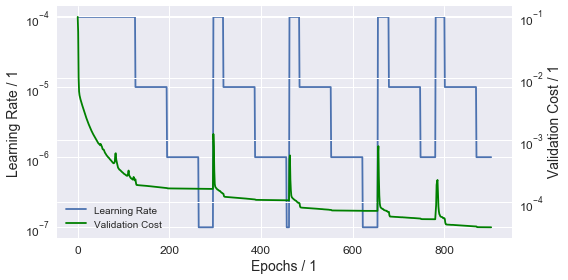

In [12]:
fig, ax1 = plt.subplots()

#ax1.semilogy(mse, label="Training")



ax1.semilogy(learning_rate, label="Learning Rate")
ax1.set_ylabel('Learning Rate / 1')
ax1.set_xlabel("Epochs / 1")

ax2 = ax1.twinx()
ax2.semilogy(mse, "g", label="Validation Cost")

ax2.set_ylabel(" Validation Cost / 1")


ax1.legend(bbox_to_anchor=(0, 0.06), loc=3)
ax2.legend(bbox_to_anchor=(0, 0), loc=3)

plt.tight_layout()

plt.savefig("/home/jo/Repos/MastersThesis/SMatrixDescriptor/figures/ExampleTrainingCost.pdf")

plt.show()


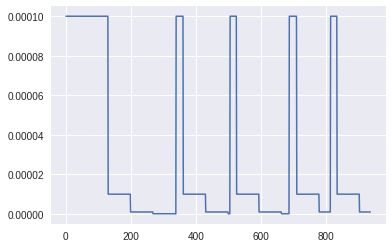